### Settings

In [1]:
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
string_pa = pd.ArrowDtype(pa.string())

# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
# pd.set_option('display.precision', 2)

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 6.0)

data_folder = Path.home() / 'python' / 'analysis' / 'ge_malaysia' / 'data'
data_files = [file for file in os.listdir(data_folder) if file.endswith('.csv')]

In [2]:
df = pd.concat(
    [
        pd.read_csv(
            os.path.join(data_folder, file),
            dtype_backend='pyarrow',
            engine='pyarrow'
        ).assign(election_term=os.path.splitext(file)[0]) 
        for file in data_files
    ],
    ignore_index=True
)

df = (
    df.assign(
        seat_code=lambda df_: df_.seat.str.split(' ', n=1, expand=True).iloc[:,0],
        seat_name=lambda df_: df_.seat.str.split(' ', n=1, expand=True).iloc[:,1]
    )
    .rename(columns={
        "voter_turnout_pct": "voter_turnout_percentage",
        "votes_cast_outside_box": "total_votes_cast",
        "votes_cast_inside_box": "valid_votes_cast",
        "votes_unreturned": "ballots_issued_but_not_returned",
        "votes_rejected": "rejected_votes",
        "votes_spoiled": "spoiled_votes",
        "total_voters": "total_registered_voters",
        "spoiled_vs_total": "spoiled_votes_percentage_of_cast_votes",
        "spoiled_vs_majority": "spoiled_votes_percentage_of_majority",
        "absent_vs_majority": "absent_voters_percentage_of_majority"
    })
    .astype({
        'election_term': string_pa,
        'majority': 'uint32[pyarrow]',
        'total_registered_voters': 'uint32[pyarrow]',
        'absent_voters': 'uint32[pyarrow]',
        'total_votes_cast': 'uint32[pyarrow]',
        'valid_votes_cast': 'uint32[pyarrow]',
        'ballots_issued_but_not_returned': 'uint32[pyarrow]',
        'rejected_votes': 'uint32[pyarrow]',
        'spoiled_votes': 'uint32[pyarrow]',
    })
    .loc[:, ['election_term', 'state', 'seat_code', 'seat_name', 'voter_turnout_percentage', 'majority', 'total_registered_voters', 'absent_voters', 'total_votes_cast', 'valid_votes_cast', 'ballots_issued_but_not_returned', 'rejected_votes', 'spoiled_votes',  'spoiled_votes_percentage_of_cast_votes', 'spoiled_votes_percentage_of_majority', 'absent_voters_percentage_of_majority']
    ]
)

percentage_columns = [
    'voter_turnout_percentage',  
    'spoiled_votes_percentage_of_cast_votes',
    'spoiled_votes_percentage_of_majority',
    'absent_voters_percentage_of_majority'
]

df[percentage_columns] = (df[percentage_columns] / 100).round(3)

In [3]:
df.sample(5)

,election_term,state,seat_code,seat_name,voter_turnout_percentage,majority,total_registered_voters,absent_voters,total_votes_cast,valid_votes_cast,ballots_issued_but_not_returned,rejected_votes,spoiled_votes,spoiled_votes_percentage_of_cast_votes,spoiled_votes_percentage_of_majority,absent_voters_percentage_of_majority
404,ge13,Sabah,P.183,Beluran,0.766,9988,24693,5778,18915,18914,1,552,553,0.029,0.055,0.578
140,ge12,Johor,P.141,Sekijang,0.76,9867,35138,8422,26716,26713,3,622,625,0.023,0.063,0.854
597,ge14,Johor,P.154,Mersing,0.795,8459,48183,9877,38306,38164,142,796,938,0.024,0.111,1.168
76,ge12,Perak,P.077,Tanjong Malim,0.712,5422,53483,15376,38107,37954,153,1344,1497,0.039,0.276,2.836
263,ge13,Pulau Pinang,P.042,Tasek Gelugor,0.89,3042,54068,5947,48121,48009,112,675,787,0.016,0.259,1.955


In [4]:
def uncontested(df):
    return df[df['total_votes_cast'].isna()][['election_term', 'state', 'seat_name']]

df_uncontested = uncontested(df)

df_uncontested

,election_term,state,seat_name
156,ge12,Johor,Pengerang
181,ge12,Sabah,Pensiangan
190,ge12,Sabah,Kalabakan
205,ge12,Sarawak,Tanjong Manis
206,ge12,Sarawak,Igan
209,ge12,Sarawak,Kanowit
213,ge12,Sarawak,Selangau
214,ge12,Sarawak,Kapit


In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 658 entries, 0 to 665
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype          
---  ------                                  --------------  -----          
 0   election_term                           658 non-null    string[pyarrow]
 1   state                                   658 non-null    string[pyarrow]
 2   seat_code                               658 non-null    string[pyarrow]
 3   seat_name                               658 non-null    string[pyarrow]
 4   voter_turnout_percentage                658 non-null    double[pyarrow]
 5   majority                                658 non-null    uint32[pyarrow]
 6   total_registered_voters                 658 non-null    uint32[pyarrow]
 7   absent_voters                           658 non-null    uint32[pyarrow]
 8   total_votes_cast                        658 non-null    uint32[pyarrow]
 9   valid_votes_cast                        658 non-

### 1. Basic Descriptive Statistics

- What is the overall voter turnout across all election terms?

In [6]:
total_votes_cast = df['total_votes_cast'].sum()
total_registered_voters = df['total_registered_voters'].sum()
overall_voter_turnout_percentage = total_votes_cast / total_registered_voters

print(f"Total Votes Cast: {total_votes_cast}")
print(f"Total Registered Voters: {total_registered_voters}")
print(f"Overall Voter Turnout Percentage: {overall_voter_turnout_percentage:.2%}")

Total Votes Cast: 31717664
Total Registered Voters: 38949498
Overall Voter Turnout Percentage: 81.43%


- What is the average majority votes for each state?

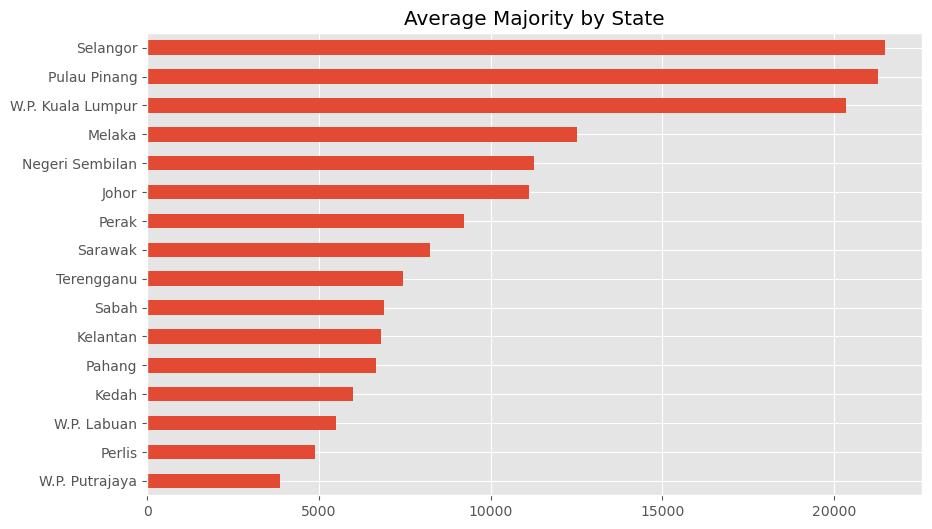

In [7]:
(
    df.groupby('state')['majority']
    .mean()
    .sort_values(ascending=True)
    .plot.barh(title="Average Majority by State")
)

plt.ylabel('')
plt.show()

In [8]:
df_majority = (
    df.groupby(['state', 'election_term'])['majority']
    .mean()
    .reset_index(name='avg_majority')
    .sort_values(by=['election_term', 'avg_majority'], ascending=[True, False])
)

election_terms = df_majority['election_term'].unique().tolist()

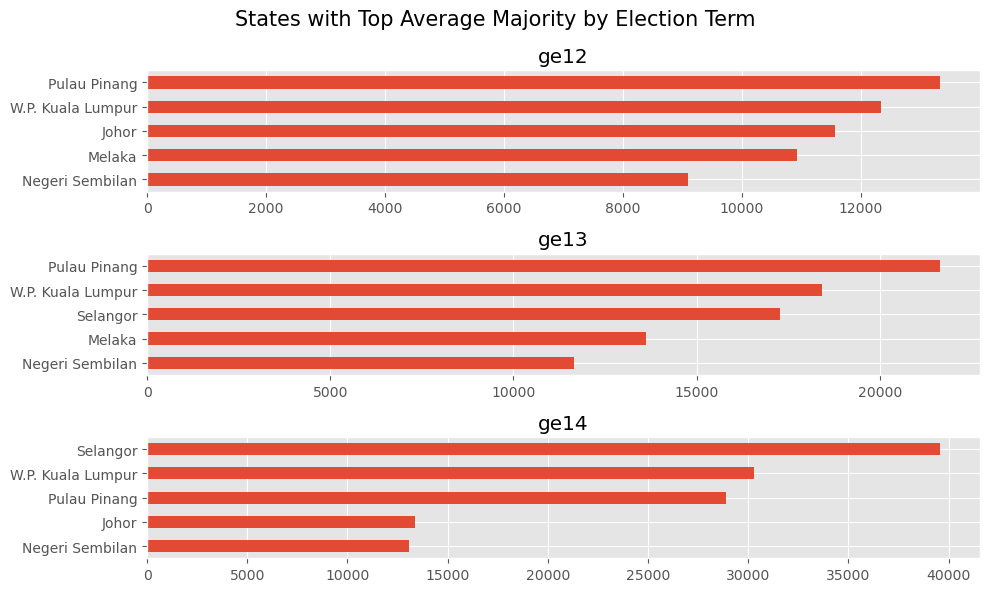

In [9]:
fig, ax = plt.subplots(len(election_terms), 1)

for i, election_term in enumerate(election_terms):
    df_plot = df_majority[df_majority['election_term'] == election_term].head(5)
    df_plot.plot(
        kind='barh',
        x='state',
        y='avg_majority',
        ax=ax[i],
        title=election_term
    )
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].legend().set_visible(False)

fig.suptitle('States with Top Average Majority by Election Term', fontsize=15)
fig.tight_layout()
plt.show()

- Explore the distribution of dataset

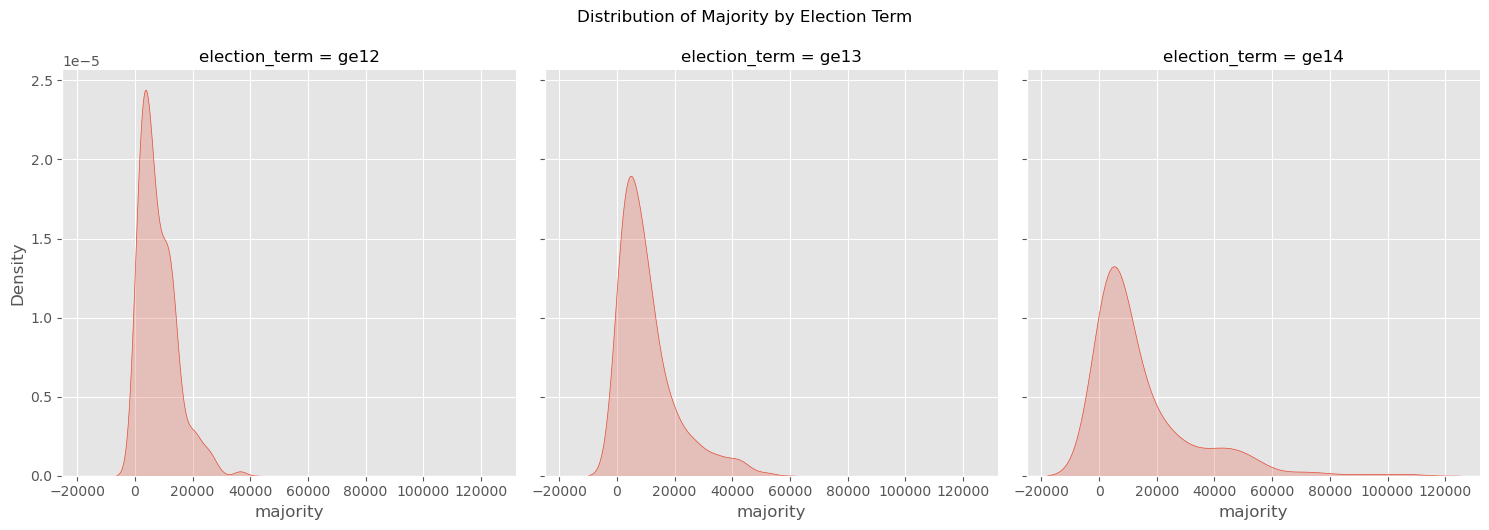

In [10]:
sns.displot(
    df,
    x='majority',
    col='election_term',
    kind='kde',
    fill=True,
    col_wrap=len(df['election_term'].unique())
)

plt.suptitle('Distribution of Majority by Election Term', y=1.05)
plt.show()

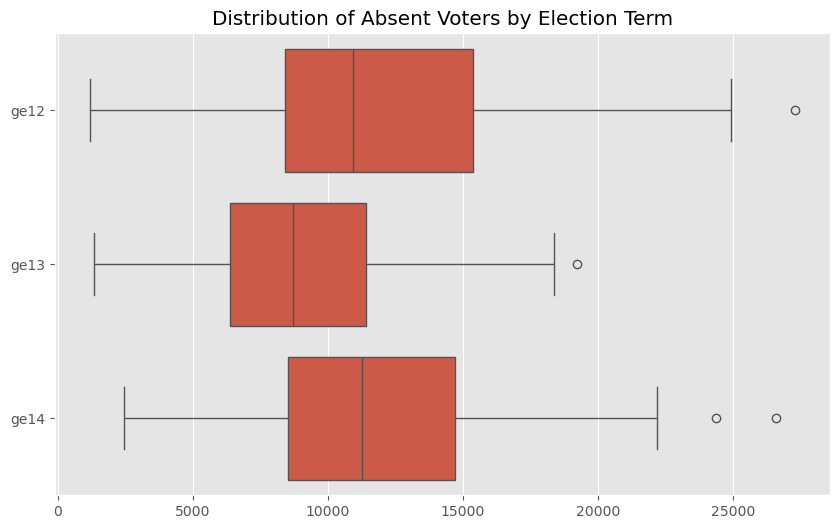

In [11]:
sns.boxplot(
    data=df,
    x='absent_voters',
    y='election_term'
)

plt.title('Distribution of Absent Voters by Election Term')
plt.xlabel('')
plt.ylabel('')
plt.show()

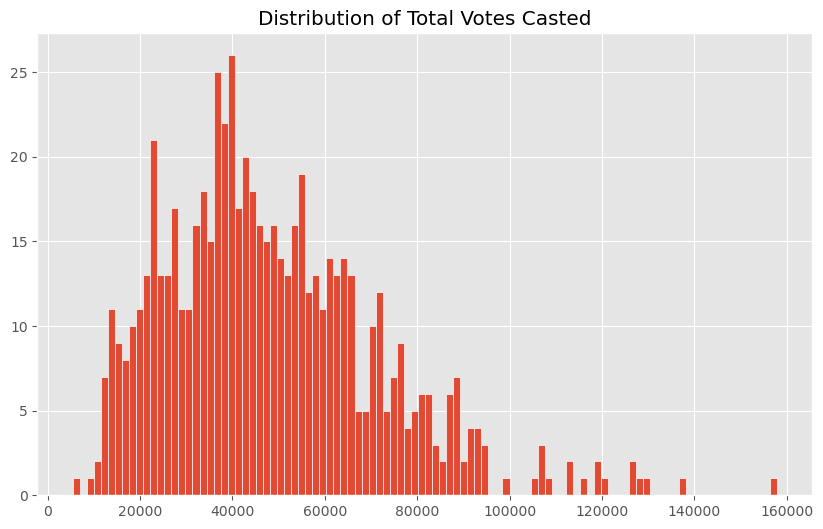

In [12]:
df['total_votes_cast'].plot(
    kind='hist',
    bins=100,
    edgecolor='white'
)

plt.title('Distribution of Total Votes Casted')
plt.xlabel('')
plt.ylabel('')
plt.show()

- What is the average percentage of spoiled votes across all seats in each election term?

In [13]:
df_spoiled = (
    df.groupby('election_term')
    .agg({'spoiled_votes_percentage_of_cast_votes': 'mean'})
    .round(4)
)

df_spoiled

,spoiled_votes_percentage_of_cast_votes
election_term,
ge12,0.0273
ge13,0.0186
ge14,0.019


In [14]:
df_spoiled = (
    df.groupby('election_term')
    .agg(
        spoiled_votes = ('spoiled_votes', 'sum'),
        votes_cast = ('total_votes_cast', 'sum'),
    )
    .assign(
        spoiled_votes_percentage_of_cast_votes = lambda x: (x['spoiled_votes'] / x['votes_cast'])
    )
    #.loc[:, ['spoiled_votes_percentage_of_votes_cast']]
)

df_spoiled

,spoiled_votes,votes_cast,spoiled_votes_percentage_of_cast_votes
election_term,,,
ge12,218249,8161052,0.026743
ge13,201658,11256545,0.017915
ge14,217088,12300067,0.017649


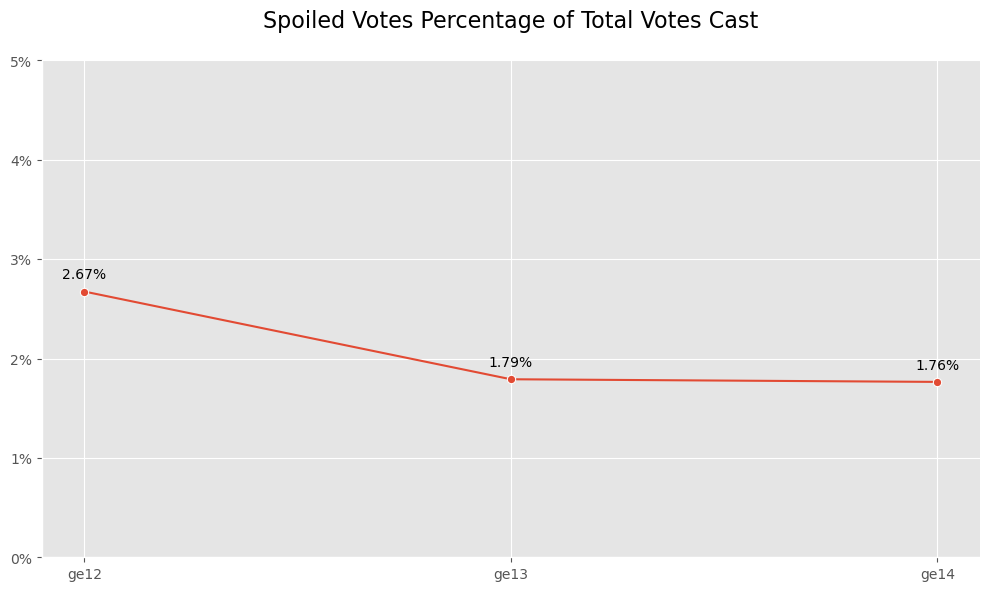

In [15]:
df_plot = df_spoiled.reset_index()

df_plot['election_term'] = df_plot['election_term'].astype('str')
df_plot['spoiled_votes_percentage_of_cast_votes'] = df_plot['spoiled_votes_percentage_of_cast_votes'].astype('float64')

sns.lineplot(
    data=df_plot,
    x='election_term',
    y='spoiled_votes_percentage_of_cast_votes',
    marker='o',
)
sns.despine()

plt.title('Spoiled Votes Percentage of Total Votes Cast', fontsize=16, y=1.05)
plt.ylabel('')
plt.xlabel('')
plt.ylim(0.0, 0.05)

for index, row in df_plot.iterrows():
    rate = row['spoiled_votes_percentage_of_cast_votes'] * 100
    
    plt.text(
        row['election_term'], 
        row['spoiled_votes_percentage_of_cast_votes'] + 0.001, 
        f'{rate:.2f}%', 
        ha='center', 
        va='bottom',
        fontsize=10
    )

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

plt.tight_layout()
plt.show()

### 2. Trends and Comparisons Across Election Terms

- How does voter turnout percentage change from GE12 to GE14? (Use a line plot to visualize changes)

In [16]:
df_turnout = (
    df.groupby('election_term')
    .agg(
        total_votes_cast = ('total_votes_cast', 'sum'),
        total_registered_voters = ('total_registered_voters', 'sum'),
    )
    .assign(
        overall_voter_turnout_percentage = lambda x: (x['total_votes_cast'] / x['total_registered_voters'])
    )
    #.loc[:, 'overall_voter_turnout_percentage']
)

df_turnout

,total_votes_cast,total_registered_voters,overall_voter_turnout_percentage
election_term,,,
ge12,8161052,10740174,0.759862
ge13,11256545,13268067,0.848394
ge14,12300067,14941257,0.823228


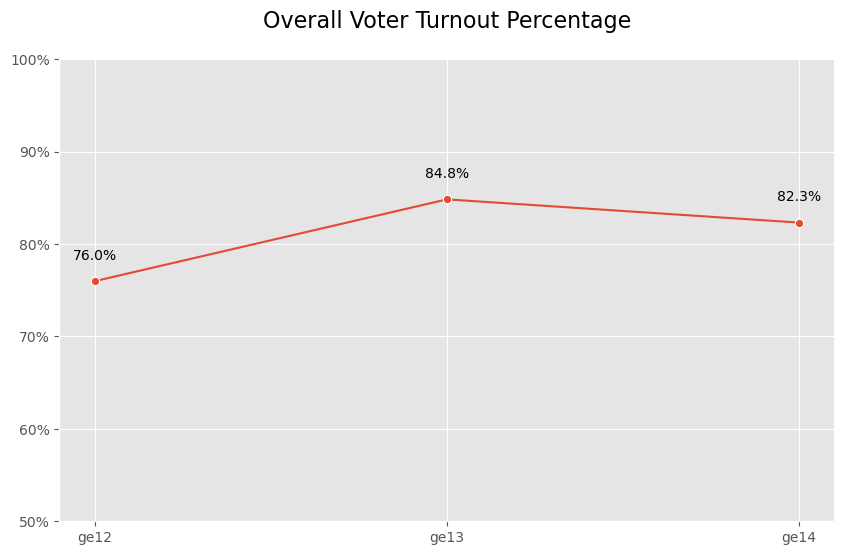

In [17]:
df_plot = df_turnout.reset_index()

# Convert PyArrow types to standard Pandas types
df_plot['election_term'] = df_plot['election_term'].astype('str')
df_plot['overall_voter_turnout_percentage'] = df_plot['overall_voter_turnout_percentage'].astype('float64')

sns.lineplot(
    data=df_plot,
    x='election_term',
    y='overall_voter_turnout_percentage',
    marker='o',
)
sns.despine()

plt.title('Overall Voter Turnout Percentage', fontsize=16, y=1.05)
plt.ylabel('')
plt.xlabel('')
plt.ylim(0.5, 1.0)

for index, row in df_plot.iterrows():
    rate = row['overall_voter_turnout_percentage'] * 100
    
    plt.text(
        row['election_term'], 
        row['overall_voter_turnout_percentage'] + 0.02, 
        f'{rate:.1f}%', 
        ha='center', 
        va='bottom',
        fontsize=10
    )

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

plt.show()

- Is there a correlation between absentee voters and spoiled votes across all election terms?
(Use scatter plots or correlation analysis)

In [18]:
correlation = df[['absent_voters', 'spoiled_votes']].corr().iloc[0, 1]
print(f"Correlation between Absentee Voters and Spoiled Votes: {correlation:.4f}")

Correlation between Absentee Voters and Spoiled Votes: 0.5064


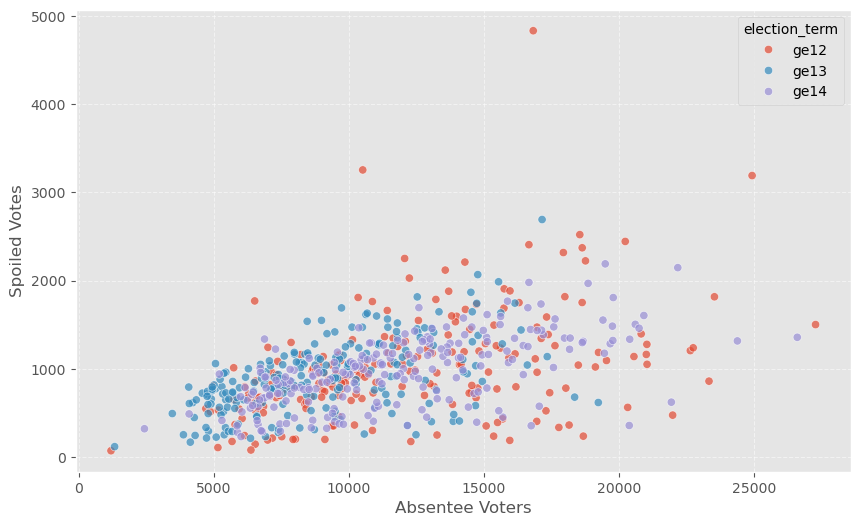

In [19]:
sns.scatterplot(
    data=df,
    x='absent_voters',
    y='spoiled_votes',
    hue='election_term',
    alpha=0.7
)

plt.xlabel("Absentee Voters")
plt.ylabel("Spoiled Votes")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [20]:
(
    df.groupby('election_term')[['absent_voters', 'spoiled_votes']]
    .corr()
    .xs('absent_voters', level=1)['spoiled_votes']
    #.iloc[0::2, -1]
)

election_term
ge12    0.432839
ge13    0.541590
ge14    0.613888
Name: spoiled_votes, dtype: float64

- What is the average number of votes cast in each state?

In [21]:
(
    pd.pivot_table(
        df,
        values='total_votes_cast',
        index='state',
        columns='election_term',
        aggfunc='mean',
        #margins=True,
        #margins_name='Overall'
    )
    .assign(Overall=lambda x: x.mean(axis=1))
    .round(0).astype(int)
    .style.background_gradient(cmap='coolwarm', subset=['Overall'])
)

election_term,ge12,ge13,ge14,Overall
state,,,,
Johor,38887,53683,59074,50548
Kedah,46482,60555,63821,56952
Kelantan,44331,55883,60061,53425
Melaka,49575,64027,70050,61217
Negeri Sembilan,44128,59372,63337,55612
Pahang,33208,44645,48321,42058
Perak,36358,48513,50600,45157
Perlis,32511,39337,41189,37679
Pulau Pinang,42667,56735,61545,53649


In [22]:
(
    pd.pivot_table(
        df,
        values='total_votes_cast',
        index='state',
        columns='election_term',
        aggfunc='mean'
    )
)

election_term,ge12,ge13,ge14
state,,,
Johor,38887.44,53683.192308,59074.115385
Kedah,46481.666667,60554.666667,63820.666667
Kelantan,44330.857143,55882.571429,60060.642857
Melaka,49575.0,64027.0,70050.166667
Negeri Sembilan,44127.625,59372.125,63337.375
Pahang,33207.714286,44644.714286,48320.857143
Perak,36358.0,48512.625,50600.5
Perlis,32510.666667,39337.333333,41189.333333
Pulau Pinang,42667.461538,56735.461538,61544.615385


### 3. Impact of Spoiled Votes and Absent Votes

- What is the relationship between spoiled votes and total votes cast in each seat?

In [23]:
correlation = (df[['spoiled_votes', 'total_votes_cast']].corr().iloc[0, 1])
print(f"Correlation between Spoiled Votes and Total Votes Cast: {correlation:.4f}")

Correlation between Spoiled Votes and Total Votes Cast: 0.5961


- How does the number of absent voters compare to the majority vote percentage across election terms?

In [24]:
(
    df.groupby('election_term')
    .agg(
        total_absentees = ('absent_voters', 'sum'),
        total_majority = ('majority', 'sum'),
    )
    .assign(
        absentees_percentage_of_majority = lambda x: (x['total_absentees'] / x['total_majority']).round(2)
    )
)

,total_absentees,total_majority,absentees_percentage_of_majority
election_term,,,
ge12,2579122,1692432,1.52
ge13,2011522,2313017,0.87
ge14,2641190,3246919,0.81


- What are the seats with the highest proportion of spoiled votes?
(Explore sorting, filtering, groupby).

In [25]:
(
    df.groupby(['state', 'seat_name'])['spoiled_votes']
    .sum()
    .reset_index()
    .sort_values(by='spoiled_votes', ascending=False)
    .head(10)
)

,state,seat_name,spoiled_votes
185,Selangor,Kapar,7620
96,Perak,Lumut,7537
180,Selangor,Bangi,6048
3,Johor,Iskandar Puteri,5772
60,Melaka,Tangga Batu,5689
67,Negeri Sembilan,Seremban,5625
199,Selangor,Sungai Buloh,5433
5,Johor,Kluang,5191
182,Selangor,Gombak,5070
79,Pahang,Pekan,5025


In [26]:
(
    df.groupby(['state', 'seat_name'])
    .agg(
        spoiled_votes = ('spoiled_votes', 'sum'),
        casted_votes = ('valid_votes_cast', 'sum')
    )
    .reset_index()
    .assign(spoiled_votes_percentage_of_casted_votes = lambda x: (x['spoiled_votes'] / x['casted_votes']).mul(100).round(2))
    .sort_values(by='spoiled_votes_percentage_of_casted_votes', ascending=False)
    .loc[:, ['state', 'seat_name', 'spoiled_votes_percentage_of_casted_votes']]
    .head(10)
)

,state,seat_name,spoiled_votes_percentage_of_casted_votes
71,Pahang,Cameron Highlands,4.8
96,Perak,Lumut,4.16
123,Sabah,Batu Sapi,4.01
139,Sabah,Putatan,3.89
105,Perak,Tapah,3.73
125,Sabah,Beluran,3.72
129,Sabah,Kinabatangan,3.72
142,Sabah,Semporna,3.49
132,Sabah,Kota Marudu,3.39
25,Johor,Tenggara,3.37


- Which states have the highest voter turnout and why might that be?

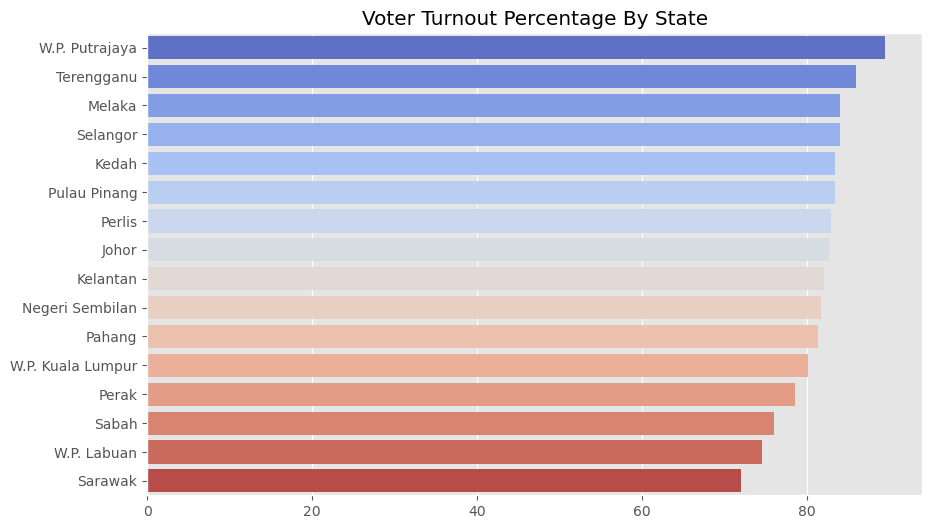

In [27]:
df_turnout = (
    df.groupby('state')
    .agg(
        total_registered_voters = ('total_registered_voters', 'sum'),
        casted_votes = ('valid_votes_cast', 'sum')
    )
    .assign(voter_turnout_percentage = lambda x: (x['casted_votes'] / x['total_registered_voters']).mul(100).round(2))
    .loc[:, ['voter_turnout_percentage']]
    .sort_values(by='voter_turnout_percentage', ascending=False)
)

sns.barplot(
    y=df_turnout.index,
    x=df_turnout['voter_turnout_percentage'],
    hue=df_turnout.index,
    palette='coolwarm',
    legend=False
)

plt.title('Voter Turnout Percentage By State')
plt.ylabel('')
plt.xlabel('')
plt.show()

### 4. Election Integrity Insights

- What is the total number of rejected votes in the last election term?

In [28]:
last_ge = sorted(df['election_term'].unique())[-1]

total_rejected_votes_last_ge = df.loc[df['election_term'] == last_ge, 'rejected_votes'].sum()
print(f"Total Rejected Votes in {last_ge.upper()}: {total_rejected_votes_last_ge}")

Total Rejected Votes in GE14: 162762


- Which seats had the most rejected votes, and what is the trend across different election terms?

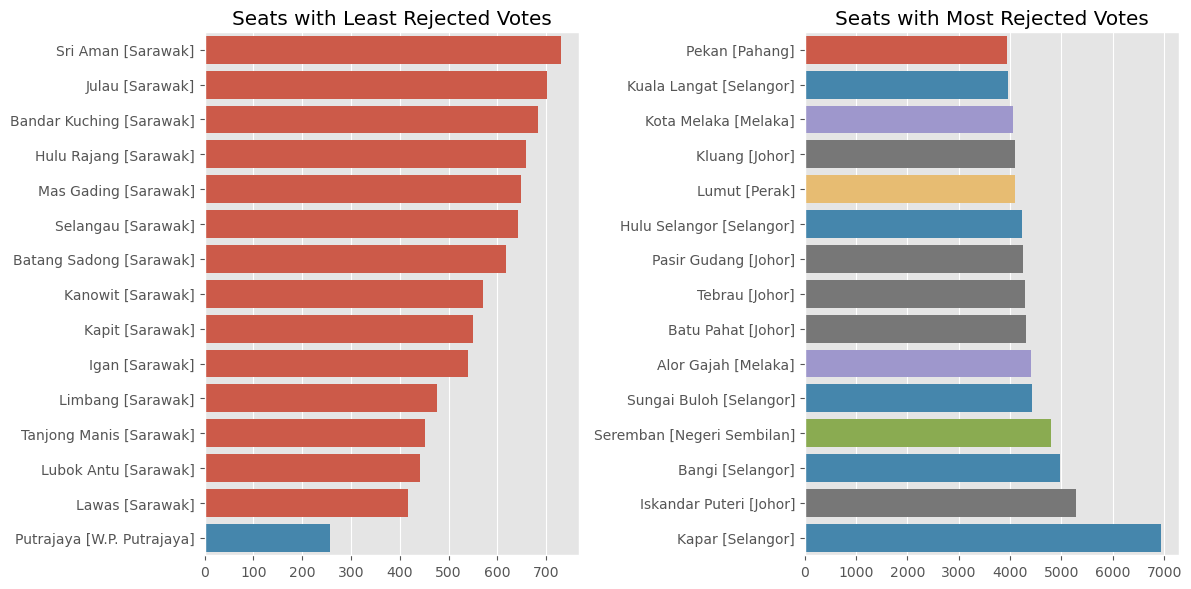

In [29]:
bottom = (
    df.groupby(['seat_name', 'state'])['rejected_votes']
    .sum()
    .reset_index()
    .pipe(lambda df: df.assign(
        seat_label = df['seat_name'] + " [" + df['state'] + "]"
    ))
    .sort_values(by='rejected_votes')
    .head(15)
)

top = (
    df.groupby(['seat_name', 'state'])['rejected_votes']
    .sum()
    .reset_index()
    .pipe(lambda df: df.assign(
        seat_label = df['seat_name'] + " [" + df['state'] + "]"
    ))
    .sort_values(by='rejected_votes')
    .tail(15)
)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot bottom
sns.barplot(
    x='rejected_votes',
    y='seat_label',
    hue='state',
    data=bottom.iloc[::-1],  # Reverse order
    ax=axes[0]
)
axes[0].set_title('Seats with Least Rejected Votes')
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].get_legend().remove()

# Plot top
sns.barplot(
    x='rejected_votes',
    y='seat_label',
    hue='state',
    data=top,
    ax=axes[1]
)
axes[1].set_title('Seats with Most Rejected Votes')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].get_legend().remove()

plt.tight_layout()
plt.show()

In [30]:
df_rejected = (
    pd.pivot_table(
        df,
        columns=['election_term'],
        index=['seat_name'],
        values=['rejected_votes'],
        aggfunc='sum',
        margins=True,
        margins_name='Overall'
    )
)

df_rejected.columns = [f"{col[1]}_{col[0]}" if col[1] else col[0] for col in df_rejected.columns]

df_rejected.sort_values(by='Overall_rejected_votes', ascending=False)

,ge12_rejected_votes,ge13_rejected_votes,ge14_rejected_votes,Overall_rejected_votes
seat_name,,,,
Overall,177246,173661,162762,513669
Kapar,3064,2379,1497,6940
Iskandar Puteri,2244,1059,1987,5290
Bangi,2072,1778,1114,4964
Seremban,2248,1486,1052,4786
...,...,...,...,...
Limbang,113,162,201,476
Tanjong Manis,<NA>,238,214,452
Lubok Antu,99,143,199,441


- What percentage of the total votes were unreturned, and how does it vary by election term?

In [31]:
df_unreturned = (
    df.groupby('election_term')
    .agg(
        unreturned_ballots = ('ballots_issued_but_not_returned', 'sum'),
        casted_votes = ('total_votes_cast', 'sum')
    )
    .assign(unreturned_ballots_percentage_of_casted_votes = lambda x: (x['unreturned_ballots'] / x['casted_votes']).mul(100).round(3))
)

df_unreturned

,unreturned_ballots,casted_votes,unreturned_ballots_percentage_of_casted_votes
election_term,,,
ge12,41003,8161052,0.502
ge13,27997,11256545,0.249
ge14,54326,12300067,0.442


- How does the number of unreturned votes compare to the majority votes across all seats?

In [32]:
df_unreturned = (
    df.groupby(['state', 'seat_name'])
    .agg(
        unreturned_ballots = ('ballots_issued_but_not_returned', 'sum'),
        majority = ('majority', 'sum')
    )
    .assign(unreturned_percentage_of_majority = lambda x: (x['unreturned_ballots'] / x['majority']).mul(100).round(3))
    .reset_index()
    .set_index('seat_name')
    .sort_values(by='unreturned_percentage_of_majority', ascending=False)
)

df_unreturned

,state,unreturned_ballots,majority,unreturned_percentage_of_majority
seat_name,,,,
Lumut,Perak,3439,8866,38.789
Bagan Serai,Perak,910,4725,19.259
Bachok,Kelantan,1185,6394,18.533
Kuala Kangsar,Perak,597,3271,18.251
Ketereh,Kelantan,1004,6000,16.733
...,...,...,...,...
Batu Kawan,Pulau Pinang,171,69000,0.248
Tanjong,Pulau Pinang,185,76733,0.241
Seputeh,W.P. Kuala Lumpur,334,144103,0.232


- Can we predict the majority votes based on absentee voters and spoiled votes? (Explore simple linear regression model.)

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [34]:
# Define predictors (independent variables) and target (dependent variable)
X = df[['absent_voters', 'spoiled_votes']]
y = df['majority']

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Get predictions
y_pred = model.predict(X_test)

In [36]:
# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 7304.21
Mean Squared Error (MSE): 152578940.16
Root Mean Squared Error (RMSE): 12352.28
R-squared (R²): 0.2802


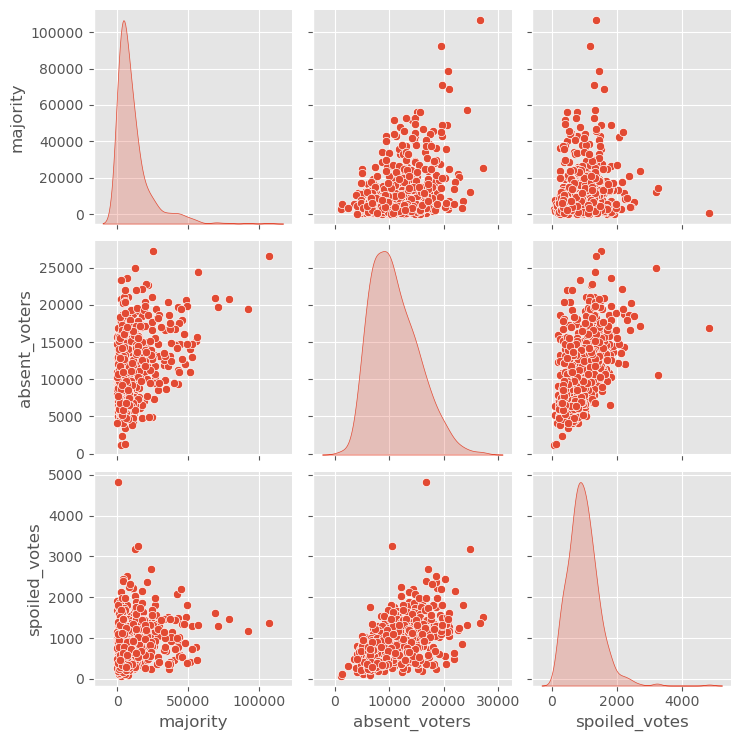

In [37]:
sns.pairplot(
    df[['majority', 'absent_voters', 'spoiled_votes']], 
    diag_kind='kde'
)
plt.show()

### 5. Election Outcomes Analysis

In [38]:
def calculate_percentage_majority(df):
    """Calculated the majority as a percentage of total votes cast."""

    df['majority_percentage'] = (df['majority'] / df['total_votes_cast']).mul(100)
    return df

def analyze_majority_percentage_distribution(df):
    """Analyzes the distribution of majority percentage"""

    sns.boxplot(
        data=df,
        x='majority_percentage',
        y='election_term'
    )
    plt.title('Distribution of Majority Percentages')
    plt.xlabel('Majority / Total Votes Cast')
    plt.show()

    print(df['majority_percentage'].describe())

def analyze_election_outcomes(df, lower=8, upper=50):
    """Analyzes election outcomes (close vs. landslide) across states and election terms."""

    df['close'] = df['majority_percentage'] < lower
    df['landslide'] = df['majority_percentage'] > upper

    # Pivot table for close fights
    close_pivot = pd.pivot_table(
        df[df['close']],
        index='state',
        columns='election_term',
        values='seat_name',
        aggfunc='count',
        fill_value=0
    )
    close_pivot.columns = [str(col) + '_close' for col in close_pivot.columns]
    close_pivot['overall_close'] = close_pivot.sum(axis=1, numeric_only=True) 

    # Pivot table for landslide fights
    landslide_pivot = pd.pivot_table(
        df[df['landslide']],
        index='state',
        columns='election_term',
        values='seat_name',
        aggfunc='count',
        fill_value=0
    )
    landslide_pivot.columns = [str(col) + '_landslide' for col in landslide_pivot.columns]
    landslide_pivot['overall_landside'] = landslide_pivot.sum(axis=1, numeric_only=True) 

    # Concatenate the pivot tables
    combined_pivot = (pd.concat([close_pivot, landslide_pivot], axis=1).fillna(0))
    combined_pivot.loc['Overall'] = combined_pivot.sum()

    return combined_pivot

In [39]:
df = calculate_percentage_majority(df)
df[['election_term', 'seat_name', 'majority', 'total_votes_cast', 'majority_percentage']].head()

,election_term,seat_name,majority,total_votes_cast,majority_percentage
0,ge12,Padang Besar,5348,29310,18.246332
1,ge12,Kangar,13671,34946,39.120357
2,ge12,Arau,300,33276,0.901551
3,ge12,Langkawi,4970,23273,21.355218
4,ge12,Jerlun,2205,37297,5.912004


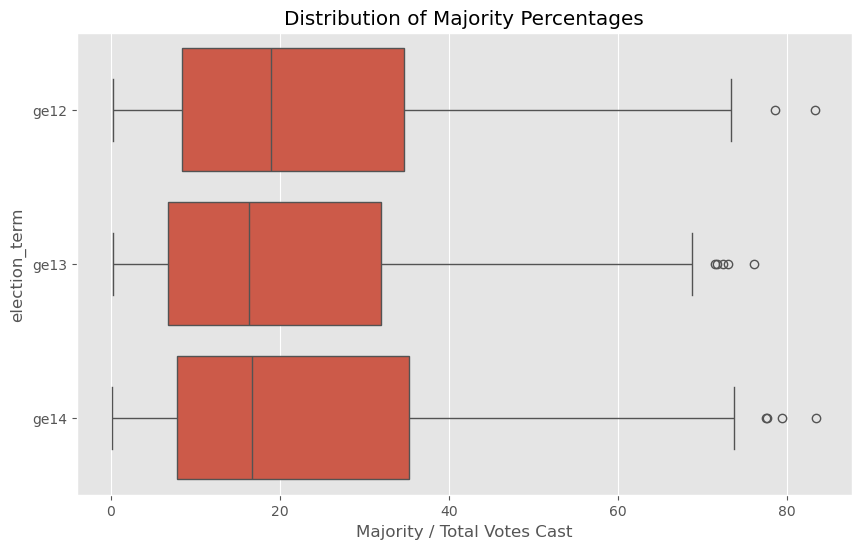

count        658.0
mean     23.142066
std       19.36183
min       0.109989
25%       7.911475
50%      17.428778
75%      34.200832
max      83.524235
Name: majority_percentage, dtype: double[pyarrow]


In [40]:
analyze_majority_percentage_distribution(df)

In [41]:
result_pivot = analyze_election_outcomes(df, lower=8, upper=50)
u = result_pivot.index.get_level_values(0)
result_pivot.style.background_gradient(cmap='coolwarm', axis=0, subset=pd.IndexSlice[u[:-1], :])

,ge12_close,ge13_close,ge14_close,overall_close,ge12_landslide,ge13_landslide,ge14_landslide,overall_landside
state,,,,,,,,
Johor,2,8,5,15,3,2,0,5
Kedah,7,10,4,21,0,0,0,0
Kelantan,5,5,4,14,0,0,0,0
Melaka,1,1,2,4,0,0,0,0
Negeri Sembilan,2,1,5,8,0,0,1,1
Pahang,5,5,6,16,1,1,0,2
Perak,8,5,7,20,0,2,3,5
Perlis,1,1,1,3,0,0,0,0
Pulau Pinang,1,2,1,4,1,6,7,14


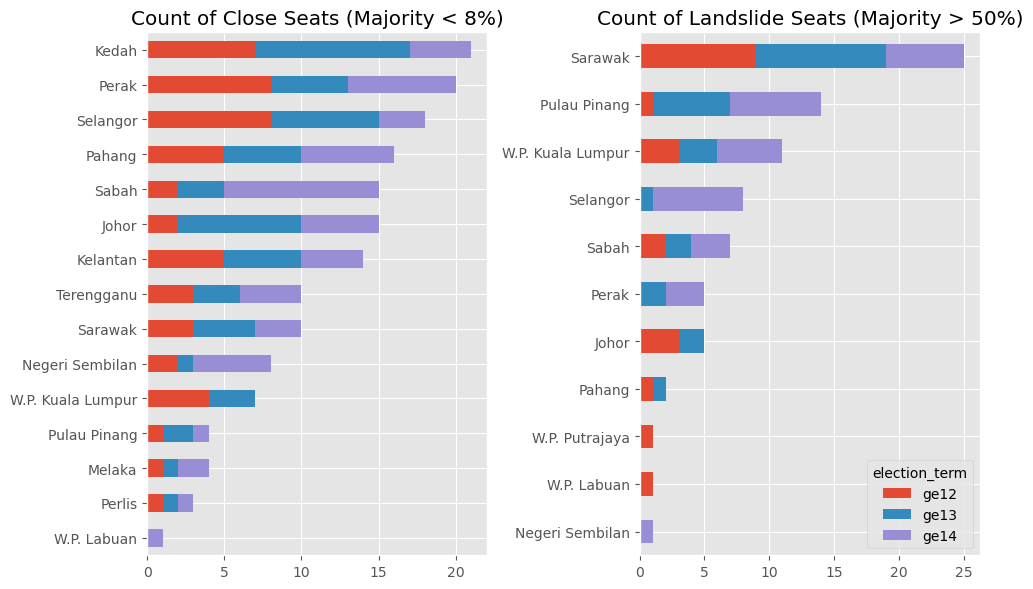

In [42]:
close_pivot = (
    pd.pivot_table(
        df[df['close']],
        index='state',
        columns='election_term',
        values='seat_name',
        aggfunc='count',
        fill_value=0
    )
    .pipe(lambda df_: df_.loc[
            df_.sum(axis=1) # sum each row
            .sort_values(ascending=True)
            .index # get the order of state for plot
        ]
    )
)

landslide_pivot = (
    pd.pivot_table(
        df[df['landslide']],
        index='state',
        columns='election_term',
        values='seat_name',
        aggfunc='count',
        fill_value=0
    )
    .pipe(lambda df_: df_.loc[
            df_.sum(axis=1)
            .sort_values(ascending=True)
            .index
        ]
    )
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

close_pivot.plot(kind='barh', stacked=True, ax=ax1)
ax1.set_title('Count of Close Seats (Majority < 8%)')
ax1.set_ylabel('')
ax1.get_legend().remove()

landslide_pivot.plot(kind='barh', stacked=True, ax=ax2)
ax2.set_title('Count of Landslide Seats (Majority > 50%)')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

### 6. GE15 - limited data available 

In [43]:
ge15_file = Path.home() / 'python' / 'analysis' / 'ge_malaysia' / 'data-clean' / 'ge15.csv'

df_ge15 = (
    pd.read_csv(
        ge15_file,
        dtype_backend='pyarrow',
        engine='pyarrow'
    )
)

df_ge15

,election_term,state,seat_code,seat_name,total_votes_cast,voter_turnout_percentage,majority,total_registered_voters,absent_voters
0,ge15,Perlis,P.001,Padang Besar,36706,0.609815,12514,60192,23486
1,ge15,Perlis,P.002,Kangar,56200,0.750745,9192,74859,18659
2,ge15,Perlis,P.003,Arau,46791,0.768628,23216,60876,14085
3,ge15,Kedah,P.004,Langkawi,47660,0.713719,13518,66777,19117
4,ge15,Kedah,P.005,Jerlun,52207,0.772281,20456,67601,15394
...,...,...,...,...,...,...,...,...,...
217,ge15,Sarawak,P.218,Sibuti,33916,0.579543,11745,58522,24606
218,ge15,Sarawak,P.219,Miri,78148,0.545616,6159,143229,65081
219,ge15,Sarawak,P.220,Baram,29783,0.50026,7339,59535,29752
220,ge15,Sarawak,P.221,Limbang,19796,0.471345,9998,41999,22203


In [44]:
df_past = df[df_ge15.columns].copy()
df_past

,election_term,state,seat_code,seat_name,total_votes_cast,voter_turnout_percentage,majority,total_registered_voters,absent_voters
0,ge12,Perlis,P.001,Padang Besar,29310,0.8,5348,36614,7304
1,ge12,Perlis,P.002,Kangar,34946,0.802,13671,43589,8643
2,ge12,Perlis,P.003,Arau,33276,0.834,300,39875,6599
3,ge12,Kedah,P.004,Langkawi,23273,0.787,4970,29568,6295
4,ge12,Kedah,P.005,Jerlun,37297,0.82,2205,45511,8214
...,...,...,...,...,...,...,...,...,...
661,ge14,Sarawak,P.218,Sibuti,22697,0.712,3676,31877,9180
662,ge14,Sarawak,P.219,Miri,58439,0.727,13663,80383,21944
663,ge14,Sarawak,P.220,Baram,22806,0.639,1990,35690,12884
664,ge14,Sarawak,P.221,Limbang,17802,0.674,7710,26412,8610


In [45]:
df = pd.concat([df_past, df_ge15], ignore_index=True)
df = df.astype({
    'majority': 'uint32[pyarrow]',
    'total_registered_voters': 'uint32[pyarrow]',
    'absent_voters': 'uint32[pyarrow]',
    'total_votes_cast': 'uint32[pyarrow]',
})
df

,election_term,state,seat_code,seat_name,total_votes_cast,voter_turnout_percentage,majority,total_registered_voters,absent_voters
0,ge12,Perlis,P.001,Padang Besar,29310,0.8,5348,36614,7304
1,ge12,Perlis,P.002,Kangar,34946,0.802,13671,43589,8643
2,ge12,Perlis,P.003,Arau,33276,0.834,300,39875,6599
3,ge12,Kedah,P.004,Langkawi,23273,0.787,4970,29568,6295
4,ge12,Kedah,P.005,Jerlun,37297,0.82,2205,45511,8214
...,...,...,...,...,...,...,...,...,...
875,ge15,Sarawak,P.218,Sibuti,33916,0.579543,11745,58522,24606
876,ge15,Sarawak,P.219,Miri,78148,0.545616,6159,143229,65081
877,ge15,Sarawak,P.220,Baram,29783,0.50026,7339,59535,29752
878,ge15,Sarawak,P.221,Limbang,19796,0.471345,9998,41999,22203


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   election_term             880 non-null    string[pyarrow]
 1   state                     880 non-null    string[pyarrow]
 2   seat_code                 880 non-null    string[pyarrow]
 3   seat_name                 880 non-null    string[pyarrow]
 4   total_votes_cast          880 non-null    uint32[pyarrow]
 5   voter_turnout_percentage  880 non-null    double[pyarrow]
 6   majority                  880 non-null    uint32[pyarrow]
 7   total_registered_voters   880 non-null    uint32[pyarrow]
 8   absent_voters             880 non-null    uint32[pyarrow]
dtypes: double[pyarrow](1), string[pyarrow](4), uint32[pyarrow](4)
memory usage: 57.0 KB


In [47]:
(
    df.groupby('election_term')
    .agg(
            registered_voters = ('total_registered_voters', 'sum'),
            votes_cast = ('total_votes_cast', 'sum')
    )
    .assign(
        registered_voters_growth = lambda x: x['registered_voters'].pct_change() * 100,
        votes_cast_growth = lambda x: x['votes_cast'].pct_change() * 100,
        voter_turnout_percentage = lambda x: (x['votes_cast'] / x['registered_voters'])
    )
)

,registered_voters,votes_cast,registered_voters_growth,votes_cast_growth,voter_turnout_percentage
election_term,,,,,
ge12,10740174,8161052,<NA>,<NA>,0.759862
ge13,13268067,11256545,23.536797,37.930073,0.848394
ge14,14941257,12300067,12.610654,9.270358,0.823228
ge15,21173638,15628365,41.712561,27.059186,0.738105


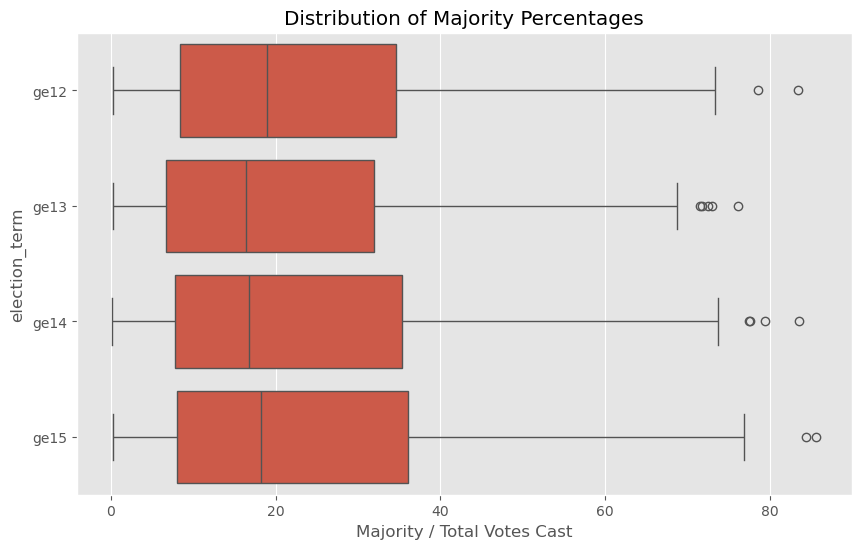

count        880.0
mean     23.538369
std       19.73339
min       0.109989
25%        7.96136
50%      17.932897
75%      34.640551
max      85.670552
Name: majority_percentage, dtype: double[pyarrow]


In [48]:
df = calculate_percentage_majority(df)
analyze_majority_percentage_distribution(df)

In [49]:
result_pivot = analyze_election_outcomes(df, lower=8, upper=50)
u = result_pivot.index.get_level_values(0)
result_pivot.style.background_gradient(cmap='coolwarm', axis=0, subset=pd.IndexSlice[u[:-1], :])

,ge12_close,ge13_close,ge14_close,ge15_close,overall_close,ge12_landslide,ge13_landslide,ge14_landslide,ge15_landslide,overall_landside
state,,,,,,,,,,
Johor,2,8,5,8,23,3,2,0,0,5
Kedah,7,10,4,1,22,0,0,0,0,0
Kelantan,5,5,4,1,15,0,0,0,2,2
Melaka,1,1,2,2,6,0,0,0,0,0
Negeri Sembilan,2,1,5,1,9,0,0,1,1,2
Pahang,5,5,6,8,24,1,1,0,0,2
Perak,8,5,7,8,28,0,2,3,3,8
Perlis,1,1,1,0,3,0,0,0,0,0
Pulau Pinang,1,2,1,3,7,1,6,7,7,21


In [50]:
df_state = (
    df.loc[
        (df['close']) & (df['state'] == 'Perak'), 
        ['election_term', 'seat_name', 'majority', 'total_votes_cast', 'majority_percentage']
    ]
)

(
    df_state
    .style
    .format({'majority_percentage': "{:.2f}%"})
    .background_gradient(cmap='coolwarm', subset=['majority_percentage'])
    #.info()
)

,election_term,seat_name,majority,total_votes_cast,majority_percentage
55,ge12,Larut,1911,30589,6.25%
58,ge12,Bukit Gantang,1566,40301,3.89%
61,ge12,Sungai Siput,1821,33154,5.49%
66,ge12,Kuala Kangsar,1458,20773,7.02%
67,ge12,Beruas,1828,30821,5.93%
69,ge12,Kampar,2697,38953,6.92%
73,ge12,Lumut,298,55930,0.53%
75,ge12,Teluk Intan,1470,36739,4.00%
271,ge13,Bagan Serai,1140,46384,2.46%
272,ge13,Bukit Gantang,986,61018,1.62%
